In [8]:
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from PIL import Image

import os, time

from pathlib import Path
import imageio
import glob

## Define some global variables
*   Latent Dimension:
> This is the number of random variables in a list that will be fed into the generator. This number is usually 100.
*   Batch Size:
> The number of samples trained at the same time. Lower is better but more computationally expensive.



In [ ]:
latent_dim = 100 #@param {type:"slider", min:0, max:100, step:100}

BATCH_SIZE = 256 #@param ["32", "64", "128", "256", "512", "1024"] {type: "raw"}

## Load in CIFAR10 Data

I combined the test and train and then filtered down to just car pictures

I then scaled the data from 0-255 to [-1,1]

This set was then given to tensorflow's dataset feature to shuffle and batch the data

In [9]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data( )

# Just take Car images
x_train = x_train[np.where([(y_train == 1) | (y_train == 7)])[1]]
x_test = x_test[np.where([(y_test == 1) | (y_test == 7)])[1]]

data = tf.concat([x_train, x_test], axis=0)

def preprocess(data):
  data = tf.cast(data, 'float32')
  return (data - 127.5) / 127.5

def undo_preprocess(data):
  return data * 127.5 + 127.5

data = preprocess(data)

data = tf.data.Dataset.from_tensor_slices(data).shuffle(60000).batch(BATCH_SIZE)

NameError: ignored

### Define Generator and Discriminator

In [ ]:
def Generator():
  model = tf.keras.Sequential(name='Generator')
  model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(latent_dim,)))

  model.add(layers.Reshape((4, 4, 512)))
  assert model.output_shape == (None, 4, 4, 512) # Note: None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 8, 8, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 16, 16, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 32, 32, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 32, 32, 3)

  return model

def Discriminator():
  model = tf.keras.Sequential(name='Discriminator')
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                    input_shape=[32, 32, 3]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same'))
  model.add(layers.LeakyReLU())

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(1))

  return model

def create_fake_data(size = 100):
  return tf.random.normal((size, latent_dim))

## Summary of Each

In [ ]:
generator = Generator()
discriminator = Discriminator()
generator.summary()
discriminator.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              819200    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 8, 8, 128)         1638400   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 8, 8, 128)         409600    
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 128)         51

tf.Tensor([[-0.0001591]], shape=(1, 1), dtype=float32)


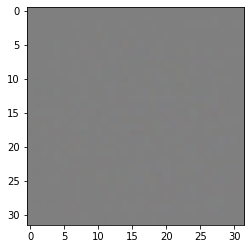

In [ ]:
x = generator(tf.random.normal([1, latent_dim]), training = False)
print(discriminator(x, training = False))
plt.imshow(tf.cast(undo_preprocess(x[0]), tf.uint8))

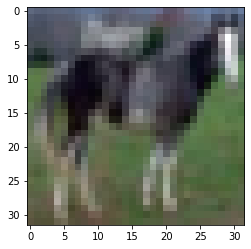

In [ ]:
plt.imshow(tf.cast(x_train[6], tf.uint8))

## Train Step

Here we define the loss functions and optimizers

Then we go through the train step and train functions

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss_function(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss * 0.5

def generator_loss_function(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)


In [ ]:
@tf.function
def train_step(real_data):
  # get random space for batch 
  latent_space = create_fake_data(BATCH_SIZE)

  with tf.GradientTape(persistent=True) as tape:

    #get fake data predictions
    fake_data = generator(latent_space, training=True)

    # compare
    real_output = discriminator(real_data, training=True)
    fake_output = discriminator(fake_data, training=True)

    discriminator_loss = discriminator_loss_function(real_output, fake_output)
    generator_loss = generator_loss_function(fake_output)

  gradients_of_generator = tape.gradient(generator_loss, generator.trainable_variables)
  gradients_of_discriminator = tape.gradient(discriminator_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  return generator_loss, discriminator_loss

def train_gan(epochs):
  latent_space_seed = create_fake_data(49)
  start_train_time = time.time()
  for epoch in range(epochs):
    start_epoch_time = time.time()
    for batch_real_data in data:
      generator_loss, discriminator_loss = train_step(batch_real_data)
    
    print("Epoch: {}/{} Time: {} --- Generator Loss: {} --- Discriminator Loss {}".format(epoch+1, epochs, time.time()-start_epoch_time, generator_loss, discriminator_loss))
    batch_generated_data = generator(latent_space_seed[:8], training=False)
    plot_generated_data(batch_generated_data)

    #if epoch % 100 == 0:
      #save_and_plot(discriminator, generator, latent_space_seed, epoch)
    

def save_and_plot(d_model, g_model, latent_space_seed, epoch):
  #d_model.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/3_Channel_GAN_Discriminator')
  #g_model.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/3_Channel_GAN_Generator')

  data = generator(latent_space_seed, training=False)
  plt.figure(figsize=(14,14))
  for i in range(data.shape[0]):
      plt.subplot(7, 7, i+1)
      plt.imshow(tf.cast(undo_preprocess(data[i]), tf.uint8))
      plt.axis('off')

  #plt.savefig('/content/drive/My Drive/Colab Notebooks/GANS/GAN GIFs/{}.png'.format(epoch))
  plt.show()


def plot_generated_data(data):
  plt.figure(figsize=(16,8))
  for i in range(data.shape[0]):
      plt.subplot(1, 8, i+1)
      plt.imshow(tf.cast(undo_preprocess(data[i]), tf.uint8))
      plt.axis('off')
  plt.show()
  

In [ ]:
train_gan(2500)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
discriminator.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/2_Item_32x32_GAN/Discriminator')
generator.save('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/2_Item_32x32_GAN/Generator')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/GANS/Saved Models/2_Item_32x32_GAN/Discriminator/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/GANS/Saved Models/2_Item_32x32_GAN/Generator/assets


In [ ]:
predictions = generator(create_fake_data(8), training=False)
plot_generated_data(predictions)

## Making the GIF

In [ ]:
image_path = Path('/content/drive/My Drive/Colab Notebooks/GANS/Saved_Plots')
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))

imageio.mimwrite('/content/drive/My Drive/Colab Notebooks/GANS/GAN GIFs/CAR_GAN.gif', image_list, fps=3)

## Option to Load and Continue Training

In [10]:
def load_both_models(path_to_g_model, path_to_d_model):
  d_model = tf.keras.models.load_model(path_to_d_model)
  g_model = tf.keras.models.load_model(path_to_g_model)
  return g_model, d_model

generator, discriminator = load_both_models('/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/2_Item_32x32_GAN/Generator',
                                            '/content/drive/My Drive/Colab Notebooks/GANS/Saved Models/2_Item_32x32_GAN/Discriminator')

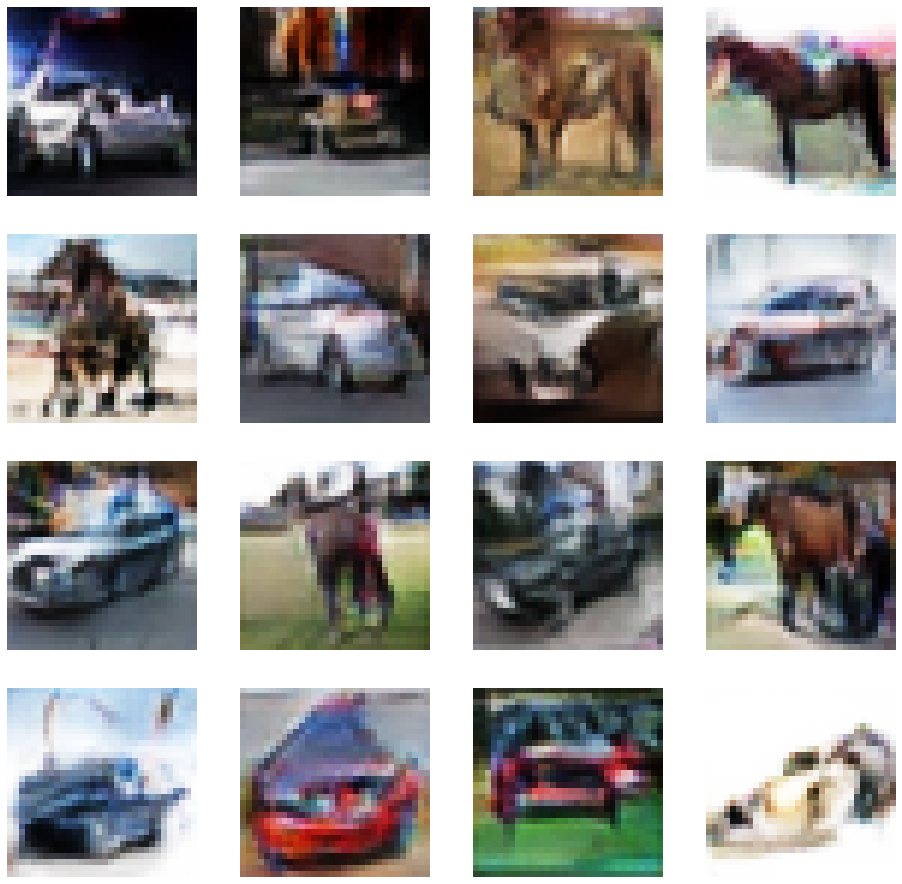

In [14]:
predictions = generator(tf.random.normal((16, 100)), training=False)

plt.figure(figsize=(16,16))
for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.cast(undo_preprocess(predictions[i]), tf.uint8))
    plt.axis('off')
plt.show()